/home/kraftb/.conda/envs/machflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Best run:  LSTM-staticall_allbasins_sqrttrans


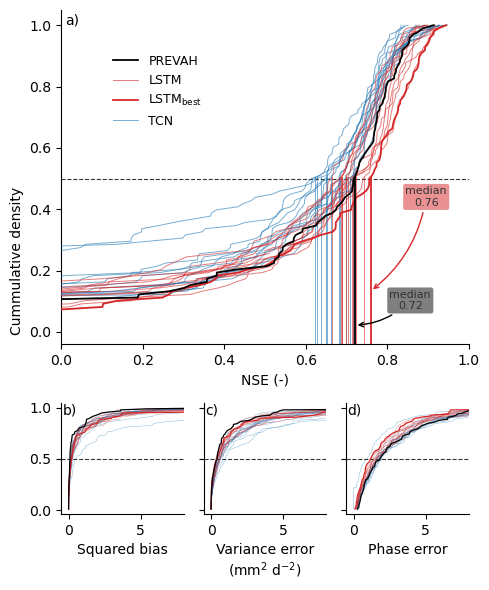

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import optuna
import numpy as np
from scipy.linalg import lstsq
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import matplotlib.ticker as plticker
from matplotlib.colors import Normalize
import matplotlib.patheffects as pe

from utils.data import load_config_xval_test_set
from utils.analysis import xval_station_metrics, get_cdf
from utils.plotting import load_default_mpl_config, savefig
from utils.metrics import compute_metrics
from utils.shapefiles import get_shapefile


load_default_mpl_config()

PLOT_PATH = Path('/net/argon/landclim/kraftb/machflow/mach-flow/analysis/figures/')
RUNS_PATH = Path('/net/argon/landclim/kraftb/machflow/runs/')
runoff_vars = ['Qmm', 'Qmm_mod', 'Qmm_prevah']


def merged_df(mod, prevah):
    x_mod = mod.to_dataframe().reset_index()
    x_mod['source'] = 'mod'
    x_pre = prevah.expand_dims(dummy=1).to_dataframe().reset_index().drop(columns=['dummy'])
    x_pre['model'] = 'PREVAH'
    x_pre['source'] = 'prevah'
    x_both = pd.concat((x_mod, x_pre)).reset_index()

    return x_both

xval_ds = xval_station_metrics(
    RUNS_PATH,
    metrics=['nse', 'bias2', 'varerr', 'phaseerr'],
    time_slices=['1995,1999', '2016,2020'])

best_run = xval_ds.nse.median('station').argmax().compute()
best_run = xval_ds.run.isel(run=best_run).item()

print('Best run: ', best_run)

def run2label(run: str) -> str:

    config_names = []

    # Handle defaults.
    if 'static' not in run:
        config_names.append(r'S$_\mathrm{area}$')

    if 'allbasins' not in run:
        config_names.append(r'C$_\mathrm{98}$')

    if 'sqrttrans' not in run:
        config_names.append(r'T$_\mathrm{none}$')

    # Handle configs.
    PROPERTY2NAME = dict(
        staticall=r'S$_\mathrm{all}$',
        staticdred=r'S$_\mathrm{PCA}$',
        allbasins=r'C$_\mathrm{267}$',
        sqrttrans=r'T$_\mathrm{sqrt}$'
    )

    model, config = run.split('-')
    config_parts = config.split('_')


    for config_part in config_parts:
        config_names.append(PROPERTY2NAME.get(config_part, 'undefined'))

    config_name = ', '.join(config_names)

    return f'{model} ({config_name})'


class ModelColors(object):
    def __init__(self, cmap: str = 'tab10'):
        self.cmap = plt.get_cmap(cmap)
        self.i = 0

    def __next__(self) -> tuple:
        color = self.cmap(self.i)
        self.i += 1
        return color

metrics = list(xval_ds.data_vars)
num_metrics = len(metrics)
ref = 'prevah'

fig = plt.figure(tight_layout=True, figsize=(5, 6))
gs = gridspec.GridSpec(2, 3, height_ratios=[3, 1])

for i, metric in enumerate(metrics):

    if i == 0:
        ax = fig.add_subplot(gs[0, :])
    else:
        ax = fig.add_subplot(gs[1, i - 1])
        ax.set_xlim(-0.5, 8)

    da = xval_ds[metric]
    rel_metrics = da - da.sel(run=ref)
    lstm_colors = ModelColors(cmap='Paired')
    tcn_colors = ModelColors(cmap='Paired')

    for run in da.run.values:

        if run == ref:
            col = 'k'
            style = '-'
            zorder = 10
            lw = 1.3
            alpha = 1
            add_annot = 10
            label = 'PREVAH'
        else:
            zorder = 8
            lw = 0.7
            alpha = 0.6
            add_annot = 0
            if run.startswith('TCN'):
                # col = next(tcn_colors)
                # style = ':'
                col = 'tab:blue'
                style = '-'
                label = 'TCN'
            else:
                # col = next(lstm_colors)
                # style = '--'
                col = 'tab:red'
                style = '-'
                label = 'LSTM'

            if run == best_run:
                # col = 'tab:green'
                alpha = 1
                lw = 1.3
                zorder = 9
                add_annot = 60
                label = r'LSTM$_\mathrm{best}$'
                # label = f'CHRUN (best): {run2label(run)}'

        if i > 0:
            lw = lw - 0.4

        # CDF plots
        # ----------------
        # ax = axes[0, i]
        ax.spines[['right', 'top']].set_visible(False)
        ax.set_xlabel(metric)

        bins, cdf, xloc = get_cdf(da.sel(run=run))

        ax.plot(bins, cdf, label=label, color=col, alpha=alpha, lw=lw, zorder=zorder,
                ls=style)

        if i == 0:
            ax.axvline(xloc, ymin=0, ymax=0.5, color=col, ls=style, alpha=alpha, lw=lw, zorder=zorder)

        if metric in ['nse', 'kge']:
            ax.set_xlim(0, 1)
        elif metric == 'absbias':
            ax.set_xlim(0, 2)

        annot_kwargs = dict(
            textcoords='offset points', ha='center', va='bottom', color='0.2',
            fontsize=8
        )

        if add_annot and i == 0:
            ax.annotate(
                f'median\n{xloc:0.2f}', xy=(xloc, add_annot / 450),
                xytext=(40,add_annot),
                bbox=dict(boxstyle='round,pad=0.2', fc=col, ec='none', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.2', color=col, alpha=1.0),
                zorder=zorder,
                **annot_kwargs)

        if metric == 'nse':
            mname = 'NSE (-)'
        elif metric == 'bias2':
            mname = 'Squared bias'
        elif metric == 'varerr':
            mname = 'Variance error\n(mm$^2$ d$^{-2}$)'
        elif metric == 'phaseerr':
            mname = 'Phase error'
        else:
            mname = 'not defined (-)'
        ax.set_xlabel(mname)

    ax.axhline(0.5, color='0.2', ls='--', alpha=1.0, lw=0.8, zorder=0)

    if i == 0:
        ax.set_ylabel('Cummulative density', y=0.25)

        handles, labels = ax.get_legend_handles_labels()
        handle_list, label_list = [], []
        order = [1, 2, 3, 0]
        # order = [1, 2, 0]
        # order = [0, 1]
        for handle, label in zip(handles, labels):
            if label not in label_list:
                handle_list.append(handle)
                label_list.append(label)
        ax.legend(
            [handle_list[idx] for idx in order],
            [label_list[idx] for idx in order],
            frameon=False,
            fontsize=9,
            loc='upper left',
            bbox_to_anchor=(0.1, 0.9))

    if i > 1:
        ax.set_yticklabels([])

    ax.text(0.01, 0.99, ['a)', 'b)', 'c)', 'd)'][i], va='top', ha='left', transform=ax.transAxes)

# savefig(fig, path=PLOT_PATH / 'fig04.png')



In [2]:
obs, obs_point = get_shapefile(source='obs', datapath='/net/argon/landclim/kraftb/machflow/data')
obs = obs.set_index('OID')
obs_point = obs_point.set_index('OID')

obs = obs.loc[xval_ds.station]
obs_point = obs_point.loc[xval_ds.station]
prevah, _ = get_shapefile(source='prevah', datapath='/net/argon/landclim/kraftb/machflow/data')

for var in xval_ds.data_vars:
    obs_point[var] = xval_ds[var].sel(run='LSTM-staticdred_allbasins_sqrttrans')
    obs_point[var + '_prevah'] = xval_ds[var].sel(run='prevah')
    obs_point[var + '_d'] = obs_point[var] - obs_point[var + '_prevah']

ERROR 1: PROJ: proj_create_from_database: Open of /home/kraftb/.conda/envs/machflow/share/proj failed


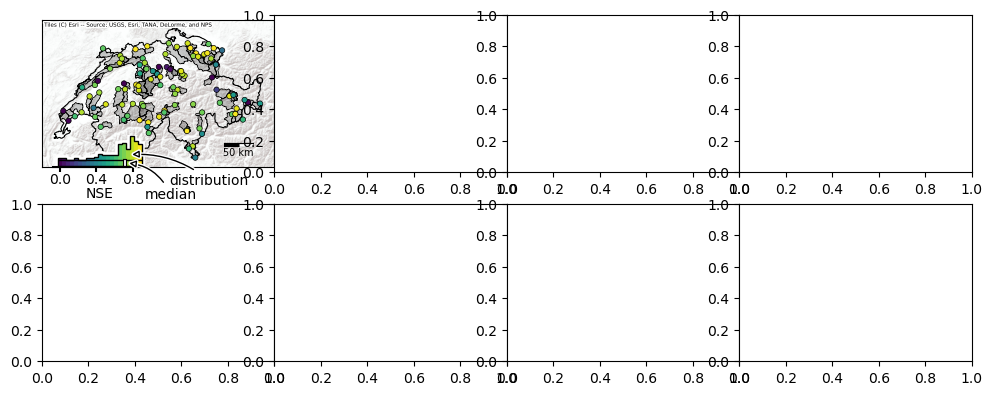

In [19]:
import contextily as cx
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as plticker
from matplotlib.colors import Normalize
import matplotlib.patheffects as pe


fig, axes = plt.subplots(2, 4, figsize=(12, 4.5), gridspec_kw={'wspace': 0})
nbins = 21

for i in range(2):
    for j, (ax, var, label) in enumerate(zip(
            axes[i, :],
            ['nse', 'bias2', 'varerr', 'phaseerr'],
            ['NSE', 'e$_\mathrm{bias}$', 'e$_\mathrm{variance}$', 'e$_\mathrm{phase}$'])):
        if (i > 0) or (j > 0):
            continue

        ax.plot(*prevah.unary_union.buffer(100).geoms[0].exterior.xy, color='k', zorder=0, lw=0.8)
        ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
        ax.margins(0.06)

        # ax.plot([780000, 800000], [100000, 100000], color='k', solid_capstyle='butt', lw=3)
        # ax.plot([790000, 799500], [100000, 100000], color='w', solid_capstyle='butt', lw=2)
        # ax.text(790000, 96000, '20 km', va='top', ha='center', size=7)

        base  = 770000
        total_len = 50000
        mid = base + 0.5 * total_len
        ax.plot([base, base + total_len], [100000, 100000], color='k', solid_capstyle='butt', lw=3)
        ax.plot([mid, base + total_len - 500], [100000, 100000], color='w', solid_capstyle='butt', lw=2)
        ax.text(mid, 96000, '50 km', va='top', ha='center', size=7)

        ax = obs.plot(
            ax=ax,
            legend=False,
            facecolor='k',
            edgecolor='none',
            alpha=0.2,
        )

        ax = obs.plot(
            ax=ax,
            legend=False,
            facecolor='none',
            edgecolor='k',
            lw=0.5,
        )

        cx.add_basemap(ax, source='Esri.WorldTerrain', crs=prevah.crs, zoom=9, zorder=-10, attribution_size=4)
        txt = ax.texts[-1]
        txt.set_position([0.01,0.98])
        txt.set_ha('left')
        txt.set_va('top')


        if i == 0:
            varname = var
            data = obs_point[var]
            vmin = 0
            vmax = data.quantile(0.95)
            if j == 0:
                cmap = 'viridis'
                loc = plticker.MultipleLocator(base=0.4)
            else:
                cmap = 'plasma_r'
                vmin = 0
                vmax = 6
                loc = plticker.MultipleLocator(base=2.5)

            label_ = label

        else:
            varname = var + '_d'
            data = obs_point[varname]
            vmin, vmax = data.quantile([0.05, 0.95])
            vabs = max(-vmin, vmax)
            vmin = -vabs
            vmax = vabs

            if j == 0:
                cmap = 'PiYG'
            else:
                cmap = 'RdBu_r'

            label_ = '$\Delta$' + label

        obs_point.plot(
            column=varname,
            legend=False,
            ax=ax,
            zorder=1,
            vmin=vmin,
            vmax=vmax,
            s=15,
            edgecolor='k',
            cmap=cmap,
            lw=0.5)

        # ax_inset = ax.inset_axes([0.05, 1, 0.4, 0.15])
        ax_inset = ax.inset_axes([0.05, 0, 0.4, 0.22])
        ax_inset.set_facecolor('none')

        # x = np.random.uniform(vmin, vmax, 1000)
        x = obs_point[varname]
        extra = (vmax - vmin) / (nbins - 1) / 2
        bins_bounds = np.linspace(vmin - extra, vmax + extra, nbins + 1)
        bin_values, bins = np.histogram(x, bins=bins_bounds)
        bin_centers = (bins_bounds[:-1] + bins_bounds[1:]) / 2
        bin_width = bin_centers[1] - bin_centers[0]

        cmap = mpl.colormaps[cmap]
        norm = Normalize(vmin=vmin, vmax=vmax)
        colors = cmap(norm(bin_centers))
        ax_inset.hist(x, bins_bounds, histtype='step', color='w', lw=4, zorder=-5)
        ax_inset.hist(x, bins_bounds, histtype='step', color='k', lw=1)
        ax_inset.bar(bin_centers, bin_values, bin_width, color=colors)
        ax_inset.set_yticks([])
        ax_inset.set_yticklabels([])
        ax_inset.spines[['left', 'top', 'right']].set_visible(False)
        ax_inset.spines['bottom'].set_linewidth(1.5)
        ax_inset.tick_params(axis='x', which='major', pad=0., width=1.5)

        mx = 0
        mn = -bin_values.max() / 4
        bs = bins_bounds[-1] - bins_bounds[0]
        ax_inset.bar(bin_centers, mn, bin_width, color=colors)
        ax_inset.add_patch(
            Rectangle((bins_bounds[0], 0), bs, mn, ec='w', fc='none', lw=4, zorder=-5))
        ax_inset.add_patch(
            Rectangle((bins_bounds[0], 0), bs, mn, ec='k', fc='none', lw=1))
        ax_inset.set_xlabel(label_, labelpad=0.)

        #ax_inset.axvline(x.median(), color='k', lw=1.8)
        #ax_inset.axvline(x.median(), color='w', lw=0.4, ymin=0.04, ymax=0.96)
        median = x.median()
        ms = (mx - mn) * 0.1
        ax_inset.plot([median, median], [mn + ms, mx - ms], color='k', lw=3)
        ax_inset.plot([median, median], [mn + ms * 2, mx - ms * 2], color='w', lw=1.3)

        if i == 0:
            ax_inset.xaxis.set_major_locator(loc)

            if j == 0:
                ax_inset.annotate('median', 
                    xy=(median + bs * 0.015, (mx + mn) / 2), xycoords='data', color='black',
                    xytext=(bs * 1., mn * 6.5), textcoords='data',
                    arrowprops=dict(arrowstyle='-|>',
                                    connectionstyle='arc3,rad=0.3',
                                    path_effects=[pe.withStroke(linewidth=3, foreground='w')],
                                    fc='w'))

                ax_inset.annotate('distribution', 
                    xy=(median + bs * 0.05, mx + 9 * ms), xycoords='data', color='black',
                    xytext=(bs * 1.3, mn * 4.2), textcoords='data',
                    arrowprops=dict(arrowstyle='-|>',
                                    connectionstyle='arc3,rad=0.2',
                                    path_effects=[pe.withStroke(linewidth=3, foreground='w')],
                                    fc='w'))

In [3]:
import xarray as xr
from scipy.stats import spearmanr

In [4]:
ds = xr.open_dataset('/net/argon/landclim/kraftb/machflow/data/harmonized_basins.zarr').sel(station=obs_point.index)

ds['Qmm_mean'] = ds.Qmm.mean('time').compute()
ds['Qmm_std'] = ds.Qmm.std('time').compute()

static_names = dict(
    water='pus01',
    urban_areas='pus02',
    coniferous_forests='pus03',
    deciduous_forests='pus04',
    mixed_forests='pus05',
    cereals='pus06',
    pasture='pus07',
    bush='pus08',
    unknown='pus10',
    firn='pus13',
    bare_ice='pus14',
    rock='pus15',
    fruits='pus18',
    vegetables='pus19',
    wheat='pus20',
    alpine_vegetation='pus21',
    wetlands='pus22',
    rough_pasture='pus23',
    sub_alpine_meadow='pus24',
    alpine_meadow='pus25',
    bare_soil_vegetation='pus26',
    corn='pus28',
    grapes='pus29',
)

static_vars = dict(
    catchment_area='area',
    soil_top_index='abb',
    area_top_index='atb',
    soil_depth='btk',
    elevation='dhm',
    glacier_morphology='glm',
    hydraulic_conductivity='kwt',
    available_field_capacity='pfc',
    slope='slp',
    q_mean='Qmm_mean',
    q_std='Qmm_std'
)

for name, uid in static_names.items():
    static_vars[name] = uid

for name, uid in static_vars.copy().items():
    if uid in ds.data_vars:
        ds = ds.rename({uid: name})

        obs_point[name] = ds[name]

    else:
        print(f'Deleting as not found in `ds`: {name} | {uid}')
        del static_vars[name]


/home/kraftb/.conda/envs/machflow/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/kraftb/.conda/envs/machflow/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


Deleting as not found in `ds`: fruits | pus18
Deleting as not found in `ds`: wheat | pus20
Deleting as not found in `ds`: rough_pasture | pus23
Deleting as not found in `ds`: corn | pus28


In [5]:
metrics = ['bias2', 'varerr', 'phaseerr']

rank_mat = np.full((len(static_vars), len(metrics)), np.nan)
rank_mat_diff = np.full((len(static_vars), len(metrics)), np.nan)

for r, metric in enumerate(metrics):
    for c, var in enumerate(static_vars):
        rank_mat[c, r] = spearmanr(obs_point[var], obs_point[metric]).statistic
        rank_mat_diff[c, r] = spearmanr(obs_point[var], obs_point[f'{metric}_d']).statistic

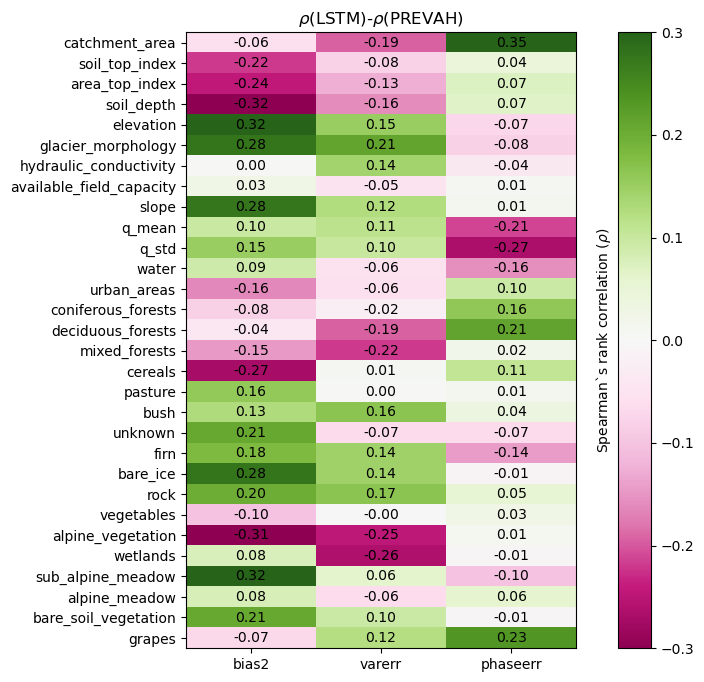

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(6, 8), gridspec_kw={'width_ratios': [12, 1]})

ax = axes[0]
mat = rank_mat_diff

im = ax.imshow(mat, aspect='auto', cmap='PiYG', vmin=-0.3, vmax=0.3)

ax.set_yticks(range(len(static_vars)))
ax.set_yticklabels(static_vars.keys());
plt.colorbar(im, cax=axes[1])

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(metrics)

for (j, i), _ in np.ndenumerate(rank_mat):
    label = f'{mat[j, i]:0.2f}'
    ax.text(i, j, label, ha='center', va='center')

ax.set_title(r'$\rho$(LSTM)-$\rho$(PREVAH)')

axes[1].set_ylabel(r'Spearman`s rank correlation ($\rho$)')
axes[1].yaxis.set_label_position('left')

In [7]:
obs_point.columns

Index(['hades_ID', 'owner_ID', 'brnnr_f_ID', 'cc_hydr_ID', 'place', 'watr_nm',
       'source', 'Shape_Area', 'cov_tabsd', 'geometry', 'is_train', 'nse',
       'nse_prevah', 'nse_d', 'bias2', 'bias2_prevah', 'bias2_d', 'varerr',
       'varerr_prevah', 'varerr_d', 'phaseerr', 'phaseerr_prevah',
       'phaseerr_d', 'catchment_area', 'soil_top_index', 'area_top_index',
       'soil_depth', 'elevation', 'glacier_morphology',
       'hydraulic_conductivity', 'available_field_capacity', 'slope', 'q_mean',
       'q_std', 'water', 'urban_areas', 'coniferous_forests',
       'deciduous_forests', 'mixed_forests', 'cereals', 'pasture', 'bush',
       'unknown', 'firn', 'bare_ice', 'rock', 'vegetables',
       'alpine_vegetation', 'wetlands', 'sub_alpine_meadow', 'alpine_meadow',
       'bare_soil_vegetation', 'grapes'],
      dtype='object')

In [8]:
from scipy.stats import ttest_ind

var_is_sig = {}

metric = 'nse_d'

metric_val = obs_point[metric].values
threshold = np.quantile(metric_val, 0.1)
is_lower = True

mask_fn = lambda x: (x < threshold) if is_lower else (x > threshold)

mask = mask_fn(metric_val)

for var in static_vars.keys():
    x = obs_point[var].values
    x_bad = x[mask]
    x_good = x[~mask]
    t = ttest_ind(x_bad, x_good, equal_var=False)
    if (t.pvalue < 0.01) and any(x_bad > 0):
        var_is_sig[var] = t.statistic

print(' | '.join(var_is_sig.keys()))
print(threshold)


q_mean | q_std
-0.2811497


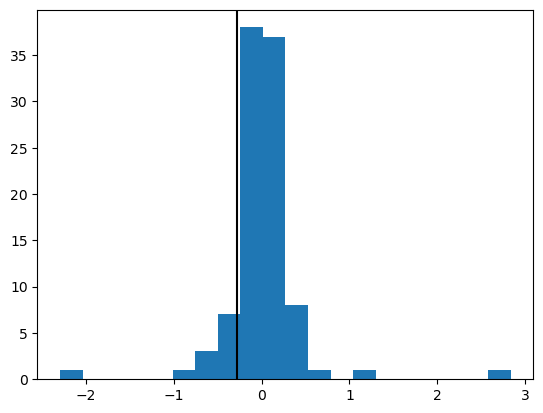

In [9]:
plt.hist(obs_point[metric].values, bins=20);
plt.axvline(threshold, color='k')

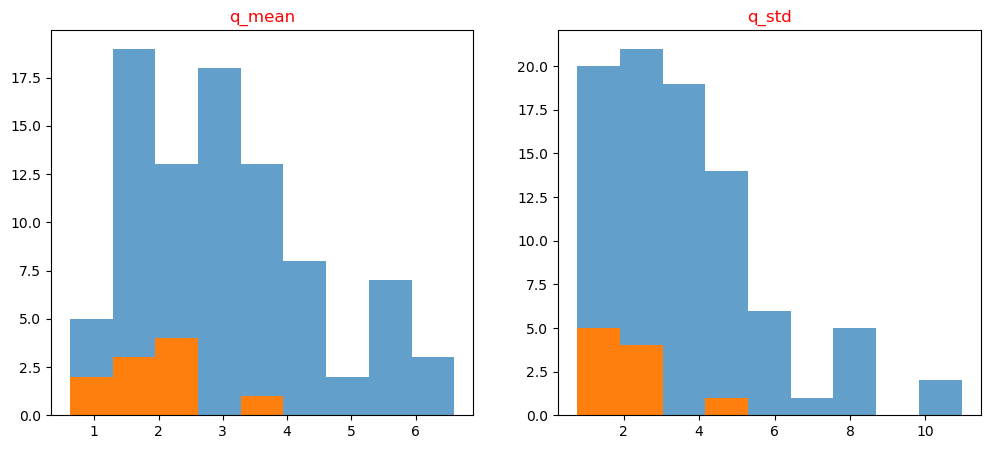

In [10]:
fig, axes = plt.subplots(1, len(var_is_sig), figsize=(12, 5), squeeze=False)

for i, (var, val) in enumerate(var_is_sig.items()):
    if val < 0:
        color = 'red'
    else:
        color = 'green'

    ax = axes[0, i]
    x = obs_point[var].values
    x_bad = x[mask]
    x_good = x[~mask]
    xmn, xmx = np.quantile(x, [0, 1])
    bins = np.linspace(xmn, xmx, 10)
    ax.hist(x_good, alpha=0.7, bins=bins)
    ax.hist(x_bad, alpha=1.0, bins=bins)
    ax.set_title(var, color=color)

In [390]:
s = obs_point.index[mask]

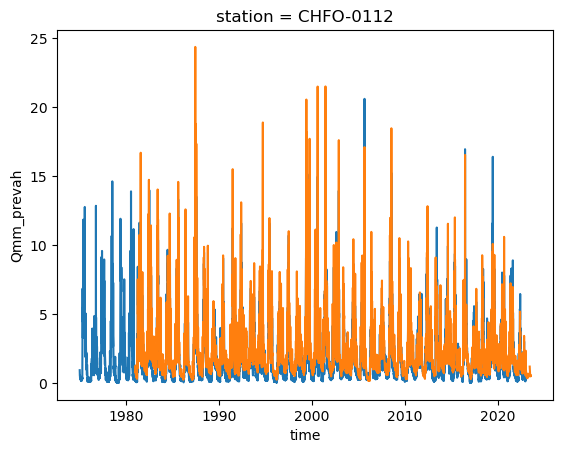

In [214]:
ds_s = ds.sel(station=s[0])
ds_s.Qmm.plot()
ds_s.Qmm_prevah.plot()

In [215]:
from utils.data import load_xval_test_set

In [216]:
ds_pred = load_xval_test_set(xval_dir='/net/argon/landclim/kraftb/machflow/runs/staticall_allbasins_sqrttrans/LSTM/xval')

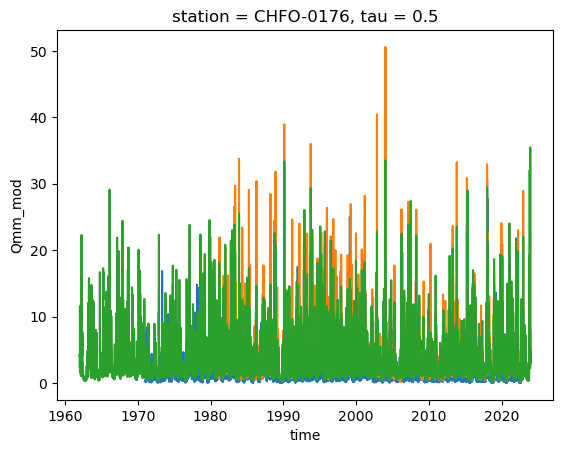

In [234]:
ds_s = ds_pred.sel(station=s[10])
ds_s.Qmm.plot()
ds_s.Qmm_prevah.plot()
ds_s.Qmm_mod.plot()

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import xarray as xr
import numpy as np
from scipy.stats import theilslopes, spearmanr
from scipy.stats.mstats import winsorize

from utils.data import load_xval_test_set
from utils.metrics import compute_metrics
from utils.plotting import load_default_mpl_config, savefig
from config import get_path_dict

load_default_mpl_config()

paths = get_path_dict()

TEST_SLICES = [slice('1995', '1999'), slice('2016', '2020')]
runoff_vars = ['Qmm', 'Qmm_mod', 'Qmm_prevah']

def common_mask_da(*da):
    mask = True
    for el in da:
        mask *= el.notnull()

    return mask


def get_masked_runoff(ds: xr.Dataset, kw: str = 'Qmm') -> xr.Dataset:
    ds_subset = ds[[var for var in list(ds.data_vars) if var.startswith(kw)]]
    
    mask = ds_subset.to_array().notnull().all('variable').compute()

    ds_subset = ds_subset.where(mask)

    return ds_subset.compute()


def resample_yearly(ds: xr.Dataset, min_frac_present: float = 0.01) -> xr.Dataset:
    ds_yearly = ds.resample(time='1YE').sum()
    ds_yearly_valid = ds.notnull().resample(time='1YE').sum()
    ds_yearly_count = ds.resample(time='1YE').count()

    ds_yearly = ds_yearly.where(ds_yearly_valid / ds_yearly_count > min_frac_present)

    return ds_yearly.compute()


def merged_df(mod, prevah):
    x_mod = mod.to_dataframe().reset_index()
    x_mod['source'] = 'mod'
    x_pre = prevah.to_dataframe().reset_index()
    x_pre['source'] = 'prevah'
    x_both = pd.concat((x_mod, x_pre)).reset_index()

    return x_both


def dfunc(x, y):
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    return (theilslopes(x, y).slope, theilslopes(x, y).intercept)


def robust_regression(x):
    trend = xr.apply_ufunc(dfunc, x, x.time,
        input_core_dims=[['time'], ['time']],
        output_core_dims=[[], []],
        output_dtypes=[float, float],
        vectorize=True)
    return trend


def plot_linreg(x, y, color, ax, **kwargs):
    sort_indices = np.argsort(x)
    x_o = x[sort_indices]
    y_o = y[sort_indices]

    x = winsorize(x_o, limits=(0.1, 0.1))
    y = winsorize(y_o, limits=(0.1, 0.1))

    X_o = sm.add_constant(x_o)
    X = sm.add_constant(x)
    ols_model = sm.OLS(y, X)
    est = ols_model.fit()
    out = est.conf_int(alpha=0.05, cols=None)

    ax.scatter(x_o, y_o, color=color, zorder=101, **kwargs)
    y_pred = est.predict(X_o)
    x_pred = x_o
    ax.plot(x_pred, y_pred, color=color, lw=1.7, zorder=100, ls='-')

    pred = est.get_prediction(X_o).summary_frame()
    ax.fill_between(x_pred, pred['mean_ci_lower'], pred['mean_ci_upper'],
                    facecolor=color, edgecolor='none', alpha=0.4)

    return est


# ds = load_xval_test_set(
#     xval_dir=paths['runs'] / 'staticall_allbasins_sqrttrans/LSTM/xval/',
#     time_slices=[
#         f'{TEST_SLICES[0].start},{TEST_SLICES[0].stop}',
#         f'{TEST_SLICES[1].start},{TEST_SLICES[1].stop}'])[runoff_vars].sel(tau=0.5).drop_vars('tau')
ds = load_xval_test_set(
    xval_dir=paths['runs'] / 'staticall_allbasins_sqrttrans/LSTM/xval/',
    time_slices=['1995,2020'])[runoff_vars].sel(tau=0.5).drop_vars('tau')
ds = get_masked_runoff(ds)
ds_yearly = resample_yearly(ds)

x_mod = compute_metrics(obs=ds_yearly.Qmm, mod=ds_yearly.Qmm_mod, dim='time')
x_prevah = compute_metrics(obs=ds_yearly.Qmm, mod=ds_yearly.Qmm_prevah, dim='time')

x_both = merged_df(mod=x_mod, prevah=x_prevah)

BOX_PROPS = {
    'boxprops':{'edgecolor': 'k', 'alpha': 0.7},
    'medianprops':{'color': 'k'},
    'whiskerprops':{'color': 'k'},
    'capprops':{'color': 'k'}
}

ds = load_xval_test_set(
    xval_dir=paths['runs'] / 'staticall_allbasins_sqrttrans/LSTM/xval/',
    time=slice('1995', None))[runoff_vars].sel(tau=0.5).drop_vars('tau')
ds = get_masked_runoff(ds)
ds_yearly = resample_yearly(ds)

ds_yearly_tid = ds_yearly.copy()
ds_yearly_tid['time'] = np.arange(len(ds_yearly_tid['time']))

metric_labels = ['r (-)', 'bias (mm d$^{-1}$)']
metrics = ['r', 'bias']

ds_trends = load_xval_test_set(
    xval_dir=paths['runs'] / 'staticall_allbasins_sqrttrans/LSTM/xval/',
    time=slice('1995', '2020'))[runoff_vars].sel(tau=0.5).drop_vars('tau')

ds_trends = get_masked_runoff(ds_trends)
ds_trends = resample_yearly(ds_trends)

ds_trends['time'] = np.arange(len(ds_trends['time']))



/net/argon/landclim/kraftb/machflow/mach-flow/utils/metrics.py:190: RuntimeWarning: All-NaN slice encountered
  qsl = np.nansum(mod_s - np.nanmin(mod_s, axis=-1, keepdims=True), axis=-1)
/net/argon/landclim/kraftb/machflow/mach-flow/utils/metrics.py:191: RuntimeWarning: All-NaN slice encountered
  qol = np.nansum(obs_s - np.nanmin(obs_s, axis=-1, keepdims=True), axis=-1)
/net/argon/landclim/kraftb/machflow/mach-flow/utils/metrics.py:190: RuntimeWarning: All-NaN slice encountered
  qsl = np.nansum(mod_s - np.nanmin(mod_s, axis=-1, keepdims=True), axis=-1)
/net/argon/landclim/kraftb/machflow/mach-flow/utils/metrics.py:191: RuntimeWarning: All-NaN slice encountered
  qol = np.nansum(obs_s - np.nanmin(obs_s, axis=-1, keepdims=True), axis=-1)


In [21]:
def dfunc(x, y):
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    res = theilslopes(x, y)
    return (res.slope, res.intercept)


def robust_regression(x):
    trend = xr.apply_ufunc(dfunc, x, x.time,
        input_core_dims=[['time'], ['time']],
        output_core_dims=[[], []],
        output_dtypes=[float, float],
        vectorize=True)
    return trend


def plot_linreg(x, y, text_y_pos, mod_name, color, ax, **kwargs):

    rlm = sm.RLM(y, sm.add_constant(x.reshape(-1, 1)), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()

    x_new = np.linspace(x.min(), x.max(), 10)
    y_new = rlm_results.predict(sm.add_constant(x_new))

    ax.scatter(x, y, color=color, zorder=101, **kwargs)
    ax.plot(x_new, y_new, color=color, lw=1.7, zorder=100, ls='-')

    r = spearmanr(x, y).statistic

    s = f'{mod_name} ($\\rho$={r:0.2f}): y={rlm_results.params[0]:0.2f} + {rlm_results.params[1]:0.2f}x'
    # f'{mod_name} (r={r:0.2f}): y={rlm_results.params[0]:0.2f} + {rlm_results.params[1]:0.2f}x'
    ax.text(0.01, text_y_pos, s, ha='left', va='top', transform=ax.transAxes, color=color, size=7,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=0.1))

    # sort_indices = np.argsort(x)
    # x_o = x[sort_indices]
    # y_o = y[sort_indices]

    # X_o = sm.add_constant(x_o)
    # X = sm.add_constant(x)
    # ols_model = sm.OLS(y, X)
    # est = ols_model.fit()
    # out = est.conf_int(alpha=0.05, cols=None)

    # ax.scatter(x_o, y_o, color=color, zorder=101, **kwargs)
    # y_pred = est.predict(X_o)
    # x_pred = x_o
    # ax.plot(x_pred, y_pred, color=color, lw=1.7, zorder=100, ls='-')

    # pred = est.get_prediction(X_o).summary_frame()
    # ax.fill_between(x_pred, pred['mean_ci_lower'], pred['mean_ci_upper'],
    #                 facecolor=color, edgecolor='none', alpha=0.4)

    # return est

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     8.693
Date:                Wed, 23 Oct 2024   Prob (F-statistic):            0.00401
Time:                        14:34:13   Log-Likelihood:                -347.00
No. Observations:                  98   AIC:                             698.0
Df Residuals:                      96   BIC:                             703.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1403      0.943      0.149      0.8

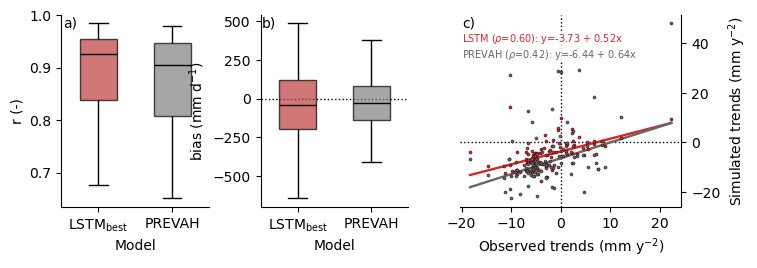

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(8, 2.5), gridspec_kw={'wspace': 0.3, 'width_ratios': [1, 1, 1.5]})

# METRICS

for i, (metric_label, metric, ax) in enumerate(zip(metric_labels, metrics, axes[:2])):
    bplot = sns.boxplot(
        data=x_both,
        x='source',
        y=metric,
        showfliers=False,
        hue='source',
        ax=ax,
        palette={'mod': 'tab:red', 'prevah': '0.5'},
        width=0.5,
        **BOX_PROPS)

    ax.set_ylabel(metric_label)
    ax.set_xticks([0, 1])
    ax.set_xticklabels([r'LSTM$_\mathrm{best}$', 'PREVAH'])
    ax.set_xlabel('Model')

    if i == 1:
        ax.axhline(color='k', lw=1.0, ls=':', zorder=-1)

ax = axes[-1]

obs_slope, obs_intercept = robust_regression(ds_trends.Qmm)
mod_slope, mod_intercept = robust_regression(ds_trends.Qmm_mod)
prevah_slope, prevah_intercept = robust_regression(ds_trends.Qmm_prevah)

r_mod = plot_linreg(
    x=obs_slope.values, y=mod_slope.values, mod_name='LSTM',
    text_y_pos=0.91, color='tab:red', ax=ax, s=5, label='LSTM', facecolor='tab:red', edgecolor='k', lw=0.3)
r_prevah = plot_linreg(
    x=obs_slope.values, y=prevah_slope.values, mod_name='PREVAH',
    text_y_pos=0.83, color='0.4', ax=ax, s=5, label='PREVAH', facecolor='0.4', edgecolor='k', lw=0.3)

# ax.text(0.01, 0.91,
#     f'LSTM (r={np.sqrt(est_mod.rsquared):0.2f}): y={est_mod.params[0]:0.2f} + {est_mod.params[1]:0.2f}x',
#         ha='left', va='top', transform=ax.transAxes, color='tab:red', size=7)
# ax.text(0.01, 0.83,
#     f'PREVAH (r={np.sqrt(est_prevah.rsquared):0.2f}): y={est_prevah.params[0]:0.2f} + {est_prevah.params[1]:0.2f}x',
#         ha='left', va='top', transform=ax.transAxes, color='k', size=7)

xmin, xmax = obs_slope.quantile([0, 1])
ymin0, ymax0 = mod_slope.quantile([0, 1])
ymin1, ymax1 = prevah_slope.quantile([0, 1])
ymin = min(ymin0, ymin1)
ymax = max(ymax0, ymax1)

ax.plot([-0.06, 0.06], [-0.06, 0.06], color='k', lw=0.7, ls='--', zorder=-1)

extra_f = 0.1
xrng = (xmax - xmin) * extra_f
xmin -= xrng
xmax += xrng
yrng = (ymax - ymin) * extra_f
ymin -= yrng
ymax += yrng

xmin = -0.07
xmax = -xmin
ymin = -0.07
ymax = 0.15

# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)

ax.axvline(0, color='k', lw=1.0, ls=':', zorder=-1)
ax.axhline(0, color='k', lw=1.0, ls=':', zorder=-1)
ax.set_xlabel('Observed trends (mm y$^{-2}$)')
ax.set_ylabel('Simulated trends (mm y$^{-2}$)')

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

for ax in axes[:-1]:
    ax.spines[['right', 'top']].set_visible(False)
axes[-1].spines[['top', 'left']].set_visible(False)

for i, ax in enumerate(axes.flat):
    ax.text(0.01, 0.99, ['a)', 'b)', 'c)'][i], ha='left', va='top', transform=ax.transAxes)

# Print trend comparison:

x = obs_slope.values
y = mod_slope.values - prevah_slope.values

X = sm.add_constant(x)
ols_model = sm.OLS(y, X)
est = ols_model.fit()

print(est.summary())

# savefig(fig, path=paths['figures'] / 'fig05.png')


In [25]:
obs_slope.isel(station=0)

<xarray.DataArray ()> Size: 8B
array(-3.71206665)
Coordinates:
    station  <U9 36B 'CHFO-0098'

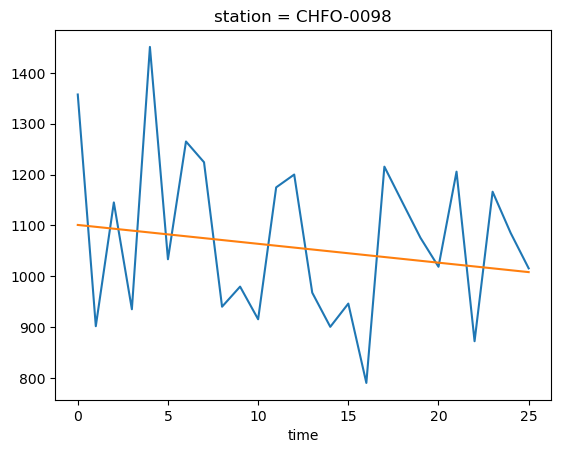

In [24]:
ds_trends.Qmm.isel(station=0).plot()
(obs_slope.isel(station=0) * ds_trends.time + obs_intercept.isel(station=0)).plot()

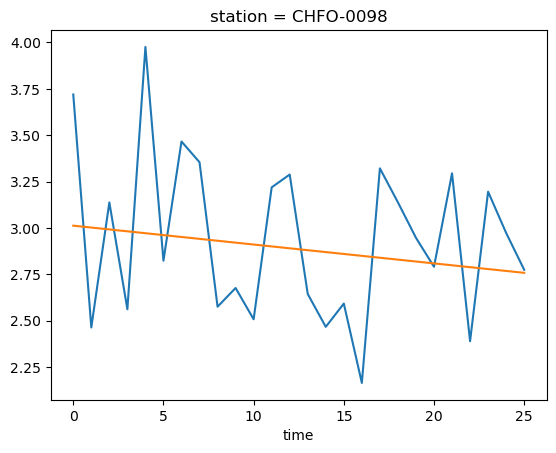

In [ ]:
ds_trends.Qmm.isel(station=0).plot()
(obs_slope.isel(station=0) * ds_trends.time + obs_intercept.isel(station=0)).plot()

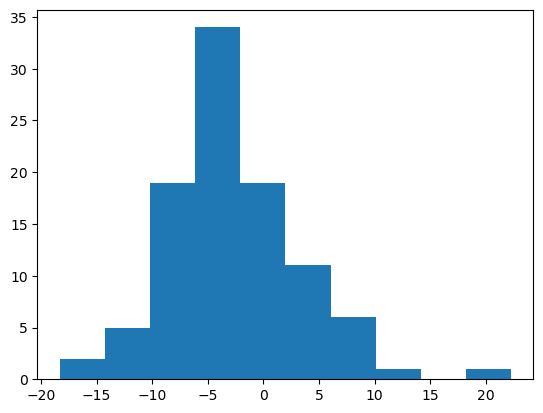

In [64]:
obs_slope.plot.hist();

In [4]:
from sklearn import linear_model
import statsmodels.api as sm

In [5]:
x = obs_slope.values.reshape(-1, 1)
y = mod_slope.values
#y = prevah_slope.values

lr = linear_model.LinearRegression()
lr.fit(x, y)

ransac = linear_model.RANSACRegressor()
ransac.fit(x, y)

# rlm = sm.RLM(y, sm.add_constant(x), M=sm.robust.norms.HuberT(t=1))
rlm = sm.RLM(y, sm.add_constant(x), M=sm.robust.norms.RamsayE())
rlm_results = rlm.fit()
rlm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                      y   No. Observations:                   98
Model:                            RLM   Df Residuals:                       96
Method:                          IRLS   Df Model:                            1
Norm:                         RamsayE                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 23 Oct 2024                                         
Time:                        12:15:08                                         
No. Iterations:                    19                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0100      0.001     -9.285      0.000      -0.012      -0.008
x1             0.5173      0.060      8.631      0.000       0.400       0.635
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [47]:
rlm_results.conf_int()

array([[-0.01216879, -0.0079269 ],
       [ 0.39984182,  0.63480023]])

0.6038227849715331


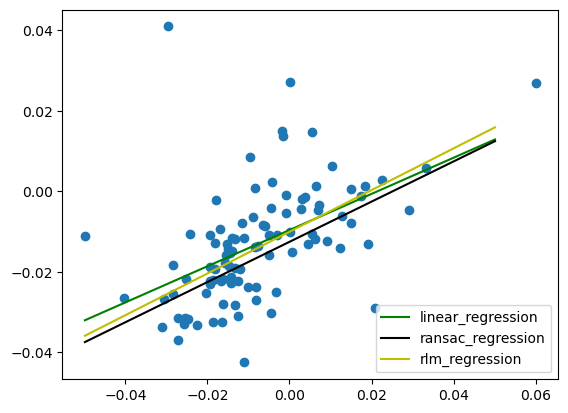

In [10]:
line_X = np.arange(x.min(), x.max(), 0.1).reshape(-1, 1)
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)
line_y_rlm = rlm_results.predict(sm.add_constant(line_X))

fig, ax = plt.subplots()

ax.scatter(x, y)
ax.plot(line_X, line_y,c="g",label="linear_regression")
ax.plot(line_X, line_y_ransac,c="k",label="ransac_regression")
ax.plot(line_X, line_y_rlm,c="y",label="rlm_regression")
ax.legend(loc='lower right')

r = spearmanr(x, y).statistic
print(r)

In [8]:
rlm_results.get

AttributeError: 'RLMResults' object has no attribute 'get_prediction'

In [14]:
import statsmodels

In [15]:
statsmodels.stats

AttributeError: module 'statsmodels.stats' has no attribute 'outliers_influence'

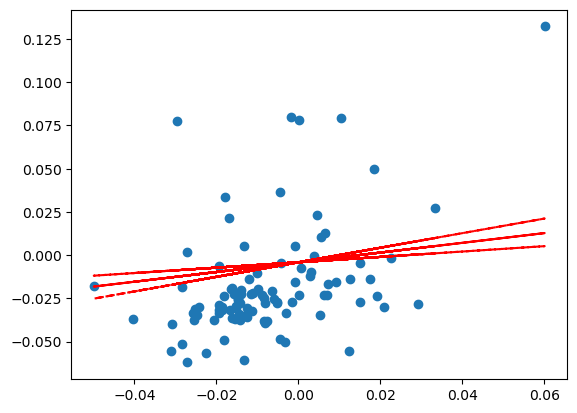

In [21]:


res = theilslopes(x, y)



ax.scatter(x, y)
ax.plot(x, res[1] + res[0] * x, 'r-')
ax.plot(x, res[1] + res[2] * x, 'r--')
ax.plot(x, res[1] + res[3] * x, 'r--')

Text(0.5, 1.0, '$\\rho$=0.01')

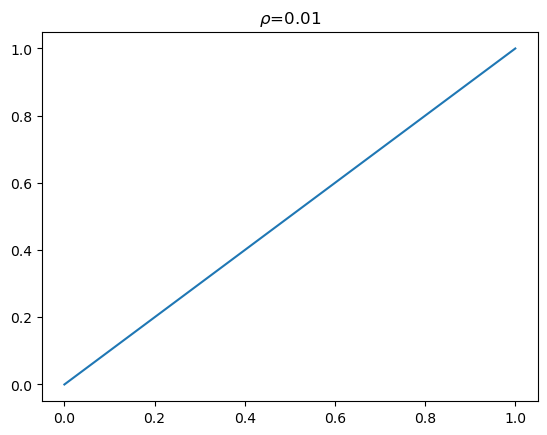

In [40]:
plt.plot([0, 1], [0, 1])
r = 0.01324
# r = f'{r:0.2f}'
s = f'$\\rho$={r:0.2f}'
plt.title(s)